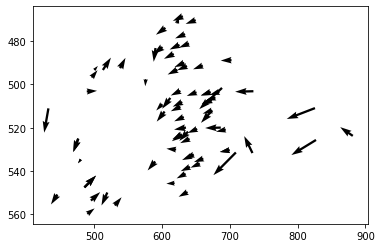

In [2]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
PATH_TO_FOLDER = "/Users/yeojunjie/Documents/NUS Modules/CS3263/Project/spacecraft-pose-estimation/data/images/0a998b28bd/"

# # Load the 100 images.
# images = []
# for i in range(0, 100):
#     PATH_TO_IMAGE = os.path.join(PATH_TO_FOLDER, "{:03d}.png".format(i))
#     image = cv.imread(PATH_TO_IMAGE)
#     images.append(image)

# Load two images.
PATH_TO_IMAGE_1 = os.path.join(PATH_TO_FOLDER, "000.png")
img = cv.imread(PATH_TO_IMAGE_1)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
PATH_TO_IMAGE_2 = os.path.join(PATH_TO_FOLDER, "001.png")
img2 = cv.imread(PATH_TO_IMAGE_2)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

# Create a SIFT detector and detect the keypoints using SIFT.
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Create a Brute Force Matcher.
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# For each match, compute the difference in the x and y coordinates of the keypoints.
# Store the differences in a list. Each element in the list is a list of four elements:
# start_X, start_Y, diff_X, diff_Y.
diffs = []
for match in matches:
    # Get the coordinates of the keypoints.
    kp1_index = match.queryIdx
    kp2_index = match.trainIdx
    kp1_coords = kp1[kp1_index].pt
    kp2_coords = kp2[kp2_index].pt
    
    # Compute the differences.
    diff_X = kp2_coords[0] - kp1_coords[0]
    diff_Y = kp2_coords[1] - kp1_coords[1]

    # Store the differences.
    diffs.append([kp1_coords[0], kp1_coords[1], diff_X, diff_Y])

# Draw a scatter graph of vectors.
diffs = np.array(diffs)
plt.quiver(diffs[:, 0], diffs[:, 1], diffs[:, 2], diffs[:, 3], angles='xy', scale_units='xy', scale=10)  # Updated scale value
plt.gca().invert_yaxis()
plt.show()

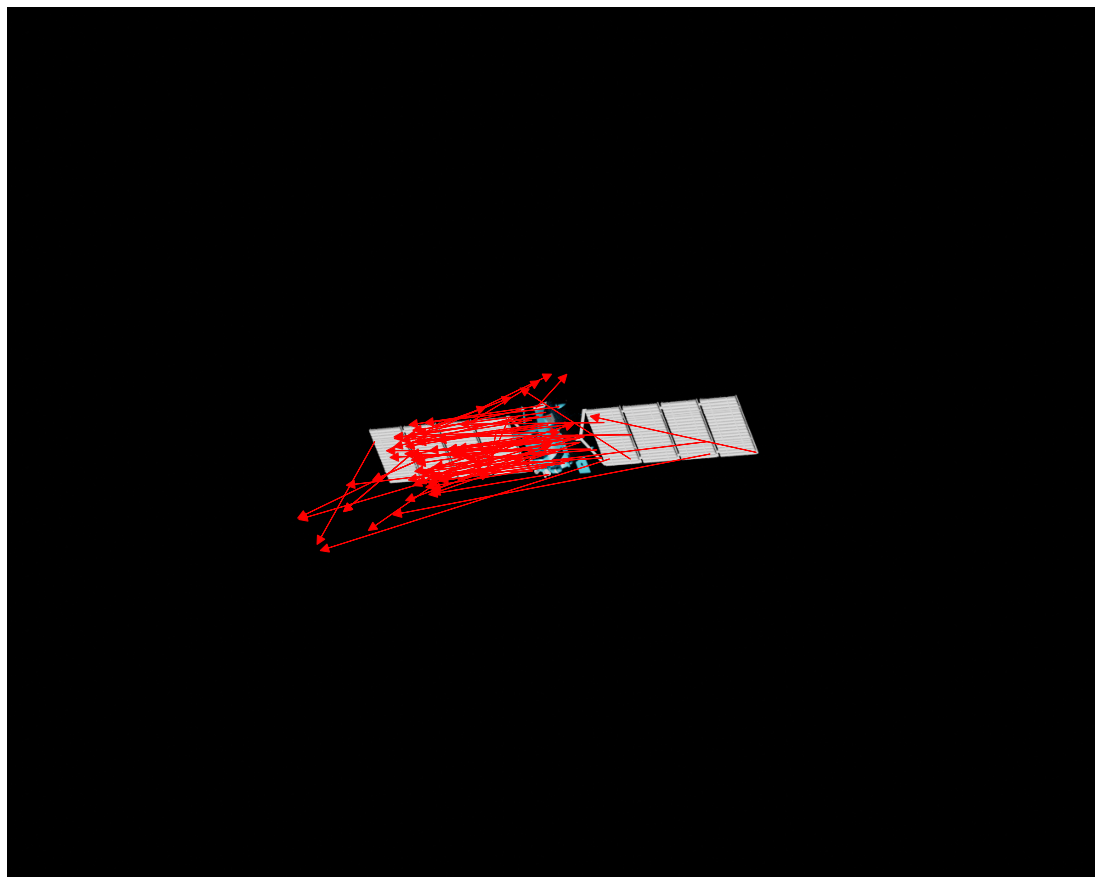

In [3]:
# Load the first image.
image1_with_vectors = img.copy()

plt.figure(figsize=(20, 16))

# Draw the vectors on top of the first image.
for diff in diffs:
    start_x, start_y, diff_x, diff_y = diff
    
    # Draw a line representing the vector.
    end_x = start_x + diff_x
    end_y = start_y + diff_y
    plt.arrow(start_x, start_y, diff_x, diff_y, color='red', head_width=10, head_length=10)
    
# Display the first image with vectors
plt.imshow(image1_with_vectors)
plt.axis('off')  # Turn off axis
plt.show()

In [23]:
# Extract corresponding points
points1 = []
points2 = []
for match in matches:
    # Get the coordinates of the keypoints.
    kp1_index = match.queryIdx
    kp2_index = match.trainIdx
    points1.append(kp1[kp1_index].pt)
    points2.append(kp2[kp2_index].pt)

# We use the RANSAC algorithm to find the fundamental matrix F.
# The fundamental matrix F 'roughly' captures the relationship between the two view points.
F, mask = cv.findFundamentalMat(np.array(points1), np.array(points2), cv.FM_RANSAC, 3.0, 0.99)

# The camera intrinsic matrix K is given.
# This describes the focal length, optical center, and skew of the camera.
# Source: https://www.drivendata.org/competitions/261/spacecraft-pose-estimation/page/834/#camera-intrinsic-parameters
K = np.array([[5.2125371e+03, 0.0000000e+00, 6.4000000e+02],
              [0.0000000e+00, 6.2550444e+03, 5.1200000e+02],
              [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])  # Intrinsic camera matrix

# We 'fine-tune' F by considering the properties of the camera (matrix K) to get the essential matrix E.
# E = K^T * F * K.
E = np.dot(np.dot(K.T, F), K)

# Decompose essential matrix to obtain translation and rotation
_, R, t, mask = cv.recoverPose(E, np.array(points1), np.array(points2), K)

# Convert the rotation matrix to right-handed quaternion.
# Source: https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions#Rotation_matrix_↔_quaternion
def rot_mat_to_quat(R):
    q = np.empty((4,))
    q[0] = np.sqrt(1 + R[0, 0] + R[1, 1] + R[2, 2]) / 2
    q[1] = (R[2, 1] - R[1, 2]) / (4 * q[0])
    q[2] = (R[0, 2] - R[2, 0]) / (4 * q[0])
    q[3] = (R[1, 0] - R[0, 1]) / (4 * q[0])
    return q

In [24]:
# Display the translation and rotation.
# Do not use scientific notation.
np.set_printoptions(suppress=True)
print("Translation:")
print(t)
print("Rotation:")
print(rot_mat_to_quat(R))

Translation:
[[-0.04405453]
 [-0.01082585]
 [ 0.99897047]]
Rotation:
[ 0.98101154  0.00236252 -0.01051658 -0.1936496 ]
